# Tutorial 3 - Sediment Routing

The latest HydroCNHS can also routing the total suspended sediment. Here, we demostrate how to construct a model that has sediment routing feature activated. We adopted a subbasin, Sb5, in Susquehena River Basin. For more details, please refer to (Lin et al., 2023).

Lin, C.-Y., Yang, Y. E., & Chaudhary, A. K. (2023). Pay-for-practice or Pay-for-performance? A coupled agent-based evaluation tool for assessing sediment management incentive policies. Journal of Hydrology, 624, 129959.

<img src="./NB_Figs/SRB_map.jpg" alt="SRB_map" width="600"/>

## Create a draft `model.yaml` using model builder

In [4]:
import os
import pandas as pd
import hydrocnhs

# Set the working directory
wd = os.path.abspath(
    os.path.join(
        os.path.dirname(hydrocnhs.__file__),
        '..', '..', 'tutorials',
        'Tutorial_3-Sediment_Routing'
        )
    )
data_path = os.path.join(wd, "Data")

# We only model a subbasin (Sb5) in this tutorial
sb = "Sb5"

# Load data
df_hu8 = pd.read_csv(os.path.join(data_path, "SRB_HU8.csv"))
df_hu8.index = list(df_hu8.ID)
df_hu8_sb = df_hu8.loc[[x for x in df_hu8["ID"] if sb in x], :]

df_agt = pd.read_csv(os.path.join(data_path, "agt_shp_info.csv"))

# Create a model using model builder
mb = hydrocnhs.ModelBuilder(wd)
mb.set_water_system("1984/01/01", "2020/12/31")
mb.set_rainfall_runoff(
    list(df_hu8_sb["ID"]),
    list(df_hu8_sb["area_ha"]),
    list(df_hu8_sb["central_la"]),
    runoff_model="GWLF"
    )

mb.set_routing_outlet(
    routing_outlet="Sb5_3",
    upstream_outlet_list=["Sb5_1", "Sb5_2", "Sb5_3"],
    flow_length_list=[113610, 113610, 0] # km
    )

# Activate sediment routing section in the model
mb.set_sediment(start_month=4)

outlets = mb.model["WaterSystem"]["Outlets"]
for o in outlets:
    mb.add_sediment(
        subbasin=o,
        area_list=list(df_agt.loc[df_agt["ID"]==o, "area_ha"]),
        cool_months=[10,11,12,1,2,3],
        K_list=list(df_agt.loc[df_agt["ID"]==o, "Value_K"]),
        Ac=0.12, Aw=0.3,
        LS_list=list(df_agt.loc[df_agt["ID"]==o, "Value_LS"]),
        DR=float(df_hu8.loc[o, "DR"]),
        id_list=list(df_agt.loc[df_agt["ID"]==o, "Agt_ID"])
        )

mb.write_model_to_yaml(filename="model.yaml")

Follow the following steps to create model & ABM script templates:
	Step 1: set_water_system()
	Step 2: set_rainfall_runoff()
	Step 3: set_routing_outlet(), one at a time.
	Step 4: (optional) set_sediment().
	Step 5: (optional) add_sediment(), one at a time.
	Step 6: (optional) set_ABM().
	Step 7: (optional) add_agent().
	Step 8: (optional) add_institution().
	Step 9: write_model_to_yaml()
	Step 10: (optional) gen_ABM_script_template()
Open the generated draft 'model.yaml' (& ABM module template) and further edit them.
Use .help to re-print the above instructions.
Model configuration file (.yaml) have been save at C:\Users\CL\Documents\GitHub\HydroCNHS\tutorials\Tutorial_3-Sediment_Routing\model.yaml. Please open the file and further edit it.


We encourage you to open `model.yaml` to give a sense of how it looks like. Users can follow the calibration steps shown in the previous tutorials to calibrate the model. Here we will skip the calibration step and adopted the calibrated parameters used in (Lin et al., 2023).

The calibrated model is located in `./Calibrated_model/Best_hydro_sed_Sb5_seed3_iter100.yaml`.

Now, let's used the calibrated model to run a simulation.

## Run sediment routing simulation 

In [ ]:
import os
import pandas as pd
import hydrocnhs
import pickle

# Load data
inputs_path = os.path.join(wd, "Inputs")

with open(os.path.join(inputs_path, "hydro_cali_1984_2020.pkl"), "rb") as file:
    (prec, temp, pet, Q_M, Q_Y, sed_M, sed_Y, _) = pickle.load(file)

with open(os.path.join(inputs_path, "cli_sed_sim_1999_2020.pkl"), "rb") as file:
    prec_sed = pickle.load(file)[0]
    
# Load model.yaml
model_dict = hydrocnhs.load_model(
    os.path.join(wd, "Calibrated_model", "Best_hydro_sed_Sb5_seed3_iter100.yaml")
    )
# Change the working directory
model_dict["Path"]["WD"] = wd

# Run the model
model = hydrocnhs.Model(model_dict)
Q = model.run(temp, prec, pet)

# Retrieve the simulated total suspended sediment (Mg)
dc = model.dc
sed_sim_m = dc.get_field("TSS_monthly", copy=True)
sed_sim_y = dc.get_field("TSS_annually", copy=True)   

100%|██████████| 13515/13515 [00:01<00:00, 8650.80it/s]


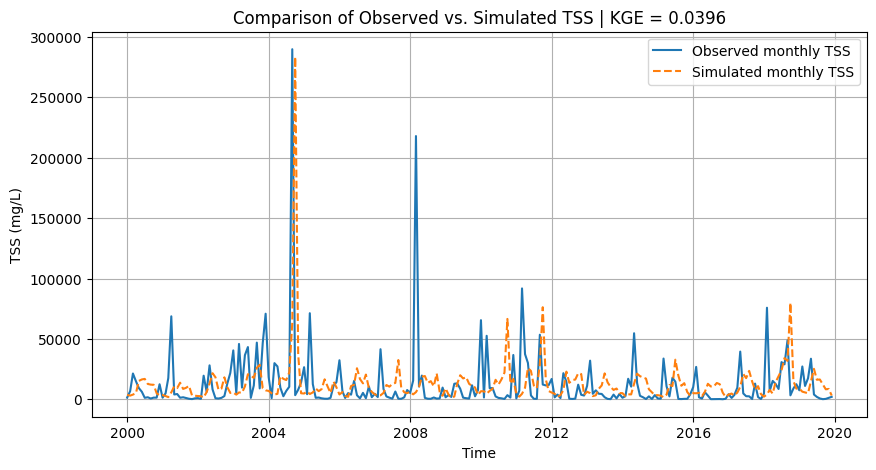

In [ ]:
import matplotlib.pyplot as plt
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot both DataFrames using sed_M index as the x-axis
x = sed_M.index
ax.plot(x, sed_M.loc[x, "Sb5_3"], label='Observed monthly TSS', linestyle='-')
ax.plot(x, sed_sim_m.loc[x, "Sb5_3"], label='Simulated monthly TSS', linestyle='--')

kge = hydrocnhs.indicators.Indicator.get_kge(sed_M.loc[x, "Sb5_3"], sed_sim_m.loc[x, "Sb5_3"])

# Labels and title
ax.set_xlabel("Dates")
ax.set_ylabel("Monthly TSS (Mg)")
ax.set_title(f"Comparison of Observed vs. Simulated TSS | KGE = {round(kge, 4)}")

# Legend and grid
ax.legend()
ax.grid(True)

plt.show()

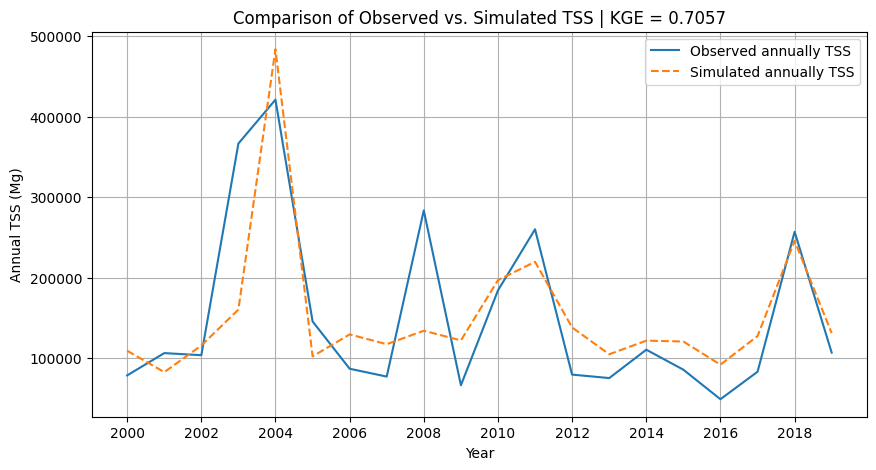

In [9]:
import matplotlib.pyplot as plt
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot both DataFrames using sed_M index as the x-axis
x = sed_Y.index
ax.plot(x, sed_Y.loc[x, "Sb5_3"], label='Observed annually TSS', linestyle='-')
ax.plot(x, sed_sim_y.loc[x, "Sb5_3"], label='Simulated annually TSS', linestyle='--')

kge = hydrocnhs.indicators.Indicator.get_kge(sed_Y.loc[x, "Sb5_3"], sed_sim_y.loc[x, "Sb5_3"])

# Labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Annual TSS (Mg)")
ax.set_title(f"Comparison of Observed vs. Simulated TSS | KGE = {round(kge, 4)}")

# Legend and grid
ax.legend()
ax.grid(True)

plt.show()

# Advance Usage
Currently, sediment simulation is done after the completion of hydrological simulation.
Therefore, users can use the Sediment module individually for more advanced opertation. 

In [12]:
# Let's save the necessary information for the sediment routing first to avoid rerunning the hydrological model.
Q_frac = dc.get_field("Q_frac", copy=True)
with open(os.path.join(inputs_path, "hydro_data.pkl"), "wb") as file:
    pickle.dump((prec, Q_frac, model_dict, sed_M, sed_Y), file)

In [ ]:
# Example start here
# import Sediment the sediment module and load data

from hydrocnhs.water_quality_model.sediment import Sediment
    
with open(os.path.join(inputs_path, "hydro_data.pkl"), "rb") as file:
    (prec, Q_frac, model_dict, sed_M, sed_Y) = pickle.load(file)

In [18]:
# Create a Sediment object
sed = Sediment(prec, Q_frac, model_dict)

# This allows you to run the sediment routing model over the entire allowable period.
# Sediment routing period will be 1 year less than the hydrological model period.
# Please see the Lin et al., 2023 for more information.
SX_routed_M, SX_routed_Y = sed.run_TSS()
sed_sim_m = sed.get_monthly_TSS()
sed_sim_y = sed.get_yearly_TSS()
print(sed_sim_m)
print(sed_sim_y)

                   Sb5_3
1984-01-01     63.213073
1984-02-01   2184.971433
1984-03-01  10287.950435
1984-04-01   7672.726796
1984-05-01  13583.503648
...                  ...
2019-08-01  16398.160534
2019-09-01  12338.600671
2019-10-01   8306.166757
2019-11-01   8572.767629
2019-12-01   3164.435686

[432 rows x 1 columns]
                    Sb5_3
1984-01-01  126627.353171
1985-01-01  101287.026707
1986-01-01  100780.170855
1987-01-01  111975.808460
1988-01-01   96964.767883
1989-01-01  126519.754815
1990-01-01  115430.020541
1991-01-01   79302.717623
1992-01-01   98740.524862
1993-01-01  169068.210102
1994-01-01  166878.045176
1995-01-01  109459.558581
1996-01-01  281555.050342
1997-01-01  170718.015681
1998-01-01  125645.964148
1999-01-01  121446.342766
2000-01-01  109526.251296
2001-01-01   82919.315613
2002-01-01  116000.608357
2003-01-01  160592.046720
2004-01-01  483912.218028
2005-01-01  102479.184207
2006-01-01  129774.018363
2007-01-01  117600.075434
2008-01-01  134314.701532


In [19]:
# On the other hand, you can run the sediment routing model for a specific period.
sed = Sediment(prec, Q_frac, model_dict)

#sed.annual_cycle_start_month

SX_routed_M, SX_routed_Y = sed.run_TSS(sed_start_date="2010/06/10", sed_end_date="2012/7/14")
sed_sim_m = sed.get_monthly_TSS()
sed_sim_y = sed.get_yearly_TSS()
print(sed_sim_m)
print(sed_sim_y)

                   Sb5_3
2010-07-01    192.064855
2010-08-01    783.439804
2010-09-01   2553.272634
2010-10-01   8081.423302
2010-11-01   3589.382796
2010-12-01  14488.986197
2011-01-01  13279.980698
2011-02-01  14204.764273
2011-03-01  20188.904232
2011-04-01  19953.026809
2011-05-01  34129.542597
2011-06-01   6529.428656
2011-07-01  11953.172686
2011-08-01   7559.853789
2011-09-01  10846.917477
2011-10-01  18111.188362
2011-11-01  14860.758489
2011-12-01  29503.827579
2012-01-01  24717.970571
2012-02-01  17813.314430
2012-03-01  18602.430171
2012-04-01  24626.022616
2012-05-01  37787.975486
2012-06-01   6750.791894
2012-07-01   5553.937470
                    Sb5_3
2011-01-01  201121.365648
2012-01-01  135852.442637


In [ ]:
# You can also run it year by year.
sed = Sediment(prec, Q_frac, model_dict)

SX_routed_M, SX_routed_Y = sed.run_next_year_TSS()
print("First year")
print(SX_routed_M)

SX_routed_M, SX_routed_Y = sed.run_next_year_TSS()
print("Second year")
print(SX_routed_M)

First year
               Sb5_1        Sb5_2         Sb5_3
1984-01-01  0.000037     0.599211     63.213073
1984-02-01  0.003579   457.375104   2184.971433
1984-03-01  0.033262  2638.015164  10287.950435
1984-04-01  0.031022   633.052565   7672.726796
1984-05-01  0.047626   741.888686  13583.503648
1984-06-01  0.038836  1380.691623  16291.642138
1984-07-01  0.025562  2623.592583  19905.434270
1984-08-01  0.022116   753.060219  16331.901021
1984-09-01  0.033564   852.625298  21587.141815
1984-10-01  0.018941   124.368864   7535.177474
1984-11-01  0.006550   466.019103   4175.398615
1984-12-01  0.024928  2431.286365   6859.339905
Second year
               Sb5_1        Sb5_2         Sb5_3
1985-01-01  0.000430     1.525307   1440.463345
1985-02-01  0.010223   559.083031   3678.595172
1985-03-01  0.015682   922.387416   6297.579771
1985-04-01  0.005369   104.788960   3468.109006
1985-05-01  0.053653  4342.355202  23245.182115
1985-06-01  0.032323   791.274894  12634.425620
1985-07-01  0.020

In [25]:
# The results are stored in the Sediment object and can be retrieved using the get_monthly_TSS and get_yearly_TSS methods.
sed_sim_m = sed.get_monthly_TSS()
sed_sim_y = sed.get_yearly_TSS()
print("Accumulated results")
print(sed_sim_m)
print(sed_sim_y)

Accumulated results
                   Sb5_3
1984-01-01     63.213073
1984-02-01   2184.971433
1984-03-01  10287.950435
1984-04-01   7672.726796
1984-05-01  13583.503648
1984-06-01  16291.642138
1984-07-01  19905.434270
1984-08-01  16331.901021
1984-09-01  21587.141815
1984-10-01   7535.177474
1984-11-01   4175.398615
1984-12-01   6859.339905
1985-01-01   1440.463345
1985-02-01   3678.595172
1985-03-01   6297.579771
1985-04-01   3468.109006
1985-05-01  23245.182115
1985-06-01  12634.425620
1985-07-01  15206.665967
1985-08-01   8574.150447
1985-09-01   6533.236958
1985-10-01   3603.299575
1985-11-01  11694.680308
1985-12-01   2341.660408
                    Sb5_3
1984-01-01  126478.400625
1985-01-01   98718.048693
